In [2]:
import io
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from AutoML import AutomatedRegression

In [3]:
# TODO add more data where pulse compression is performed?
# TODO add cross poll if sentinel-xarray has noise floor
# TODO use training data from half the image and apply on the other
# TODO use normalized backscatter ?
# TODO ship/bright signal removal?

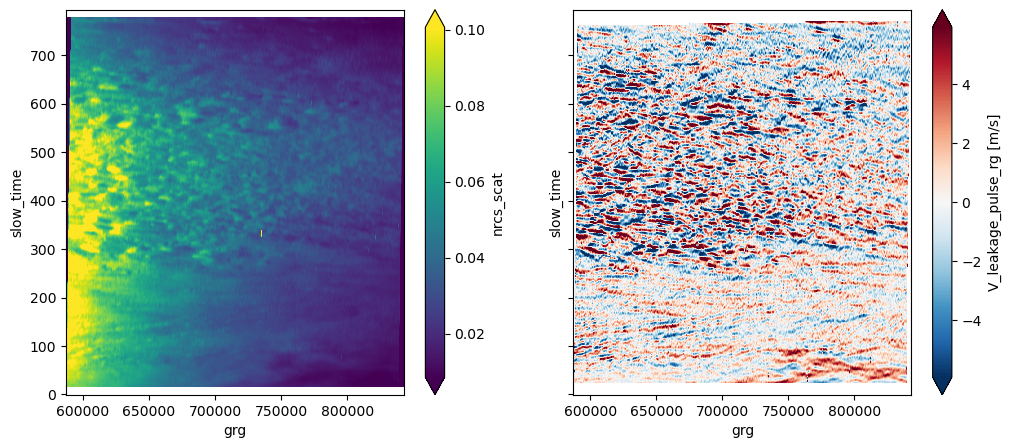

In [4]:
data = xr.open_dataset('scatt4ML2.nc')
# data = data.dropna(dim= 'slow_time', how = 'all').dropna(dim='grg', how='any')

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
data.nrcs_scat.T.plot(robust=True, ax = axes[0])
data.V_leakage_pulse_rg.T.plot(robust=True, ax = axes[1])

In [5]:
n = 20
spacing_slow_time = n # pixels
spacing_ground_range = 10 # pixels
test_range_slow_time = (200, 400) # pixels

X_data = xr.concat([data.nrcs_scat.isel(slow_time=slice(i-n, 1+i+n)) for i in range(n, len(data.nrcs_scat['slow_time'])-n)], dim='placeholder')
y_data = xr.concat([data.V_leakage_pulse_rg.isel(slow_time=i) for i in range(n, len(data.V_leakage_pulse_rg['slow_time'])-n)], dim='placeholder')

## - Train / Test data

In order to improve training data is sampled with spacing in range and slow time. This avoids including neighbouring or successive samples which are statistically similar to each other, leading towards too heaviliy idealized training conditions and overfitting. By spacing each sample they are (more) independent providing more reliable data.

In [6]:
# Training

X_train = X_data.isel(placeholder=slice(None, test_range_slow_time[0] -1))               # before slice
X_train = xr.concat([X_train, X_data.isel(placeholder=slice(test_range_slow_time[1] + 1, None))], dim='placeholder') # after slice
X_train_spaced = X_train.isel(placeholder=slice(None,None, spacing_slow_time), grg=slice(None,None, spacing_ground_range)).values.reshape(-1, 2*n+1)

y_train = y_data.isel(placeholder=slice(None, test_range_slow_time[0] -1))               # before slice
y_train = xr.concat([y_train, y_data.isel(placeholder=slice(test_range_slow_time[1] + 1, None))], dim='placeholder') 
y_train_spaced = y_train.isel(placeholder=slice(None,None, spacing_slow_time), grg=slice(None,None, spacing_ground_range)).values.reshape(-1)

data_train = pd.DataFrame(np.column_stack((X_train_spaced,y_train_spaced))).dropna()
X_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]

In [7]:
# Testing

X_test = X_data.isel(placeholder=slice(*test_range_slow_time)).values.reshape(-1, 2*n+1)
y_test = y_data.isel(placeholder=slice(*test_range_slow_time)).values.reshape(-1)

data_test = pd.DataFrame(np.column_stack((X_test,y_test))).dropna()
X_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:,-1]

print(X_test.shape, X_train.shape, y_test.shape, y_train.shape )

(148180, 41) (1933, 41) (148180,) (1933,)


## - Regression

In [9]:
# Instantiate model and overwrite automated Train / Test split

ML = AutomatedRegression(
    X=X_test,           # NOTE these are overwritten 
    y=X_test,           # NOTE these are overwritten 
    n_trial=50,
    models_to_optimize=['bayesianridge', 'lightgbm'],
    reload_study=True,
    reload_trial_cap=True,
    write_folder='/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/n_30_V_split_scene_spaced_traintest/',
)

ML.X_test = X_test
ML.X_train = X_train
ML.y_test = y_test 
ML.y_train = y_train 

/Users/opodriscoll/Documents/Scripts/DopSCA/src/automl/AutoML/automl.py:236: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_columns = (~self.X.applymap(np.isreal).any(axis = 0))


In [10]:
# hideous warning catcher
with warnings.catch_warnings(record=True) as caught_warnings:
    output_buffer = io.StringIO()
    sys.stdout = output_buffer

    result = ML.apply()
    
sys.stdout = sys.__stdout__

[I 2023-11-24 16:46:52,162] Using an existing study with name 'regression_bayesianridge' instead of creating a new one.
[I 2023-11-24 16:46:52,241] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-11-24 16:46:52,284] Using an existing study with name 'regression_bayesianridge' instead of creating a new one.
[I 2023-11-24 16:46:52,327] Using an existing study with name 'regression_lightgbm' instead of creating a new one.


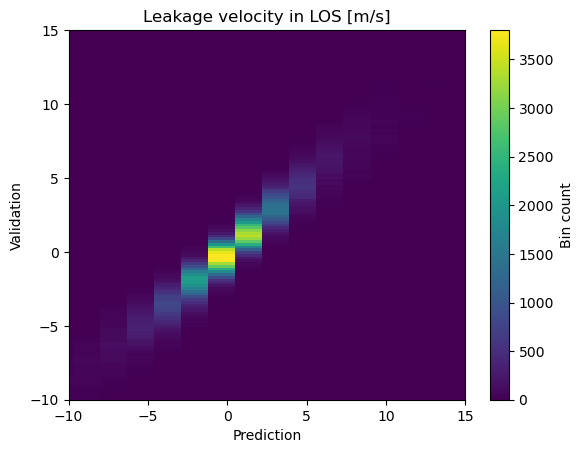

{'bayesianridge_best': [[0.5294212972783647, 0.0054994355586541095],
  [0.19108979102991341, 0.4626113499563886]],
 'lightgbm_best': [[0.5673265298356023, 0.0034305620876257346],
  [0.8686781930683386, 0.003197984290496914]],
 'stacked': [[0.4315080416616762, 0.0012399723930935848],
  [0.7848270541263116, 0.09586101117363757]]}

In [11]:
plt.hist2d(ML.y_pred, np.ravel(ML.y_test.values), bins=(200,200)) #, gridsize=10, cmap='Blues', edgecolors='gray', mincnt=1)
plt.xlim([-10, 15]); plt.ylim([-10, 15])
plt.colorbar(label='Bin count')
plt.title('Leakage velocity in LOS [m/s]')
plt.xlabel('Prediction')
plt.ylabel('Validation')
plt.show()

ML.summary

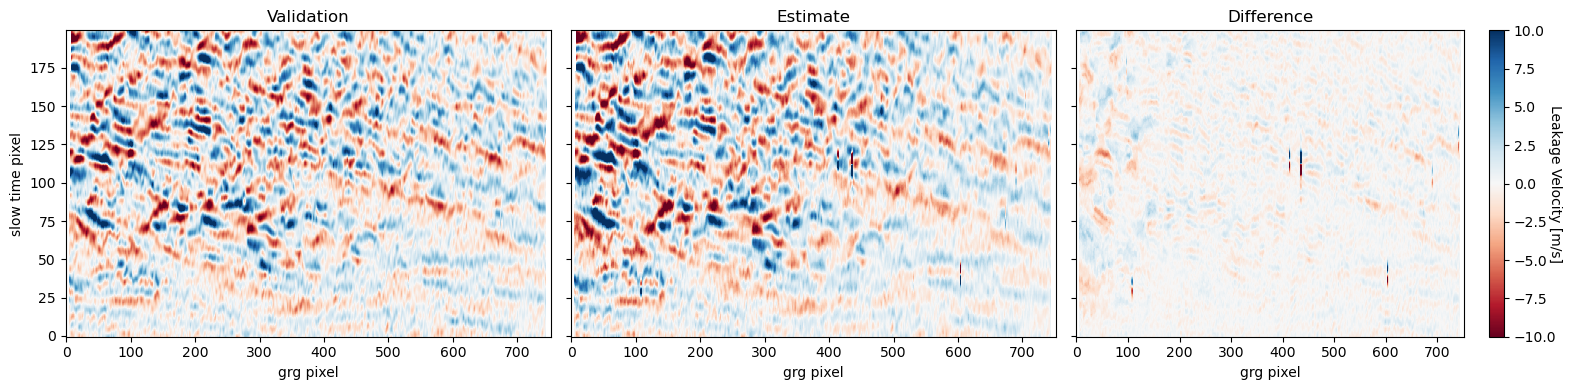

In [20]:
theoretical_length = y_data.isel(placeholder=slice(*test_range_slow_time)).values.reshape(-1).shape
A = np.nan * np.arange(theoretical_length[0])
A[y_test.index.values] = ML.y_test.values
A = A.reshape((test_range_slow_time[1] - test_range_slow_time[0], -1))

B = np.nan * np.arange(theoretical_length[0])
B[y_test.index.values] = ML.y_pred
B = B.reshape((test_range_slow_time[1] - test_range_slow_time[0], -1))

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)

vmin = -10;
vmax = 10
im0 = axes[0].imshow(A, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu')
im1 = axes[1].imshow(B.reshape((test_range_slow_time[1] - test_range_slow_time[0], -1)), origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu')
im2 = axes[2].imshow(A - B, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu')
[ax.set_xlabel('grg pixel') for ax in axes]
axes[0].set_ylabel('slow time pixel')
axes[0].set_title('Validation')
axes[1].set_title('Estimate')
axes[2].set_title('Difference')
cbar = plt.colorbar(im0, ax=axes[2])
cbar.ax.set_ylabel('Leakage Velocity [m/s]', rotation=270)
fig.tight_layout()

## Considering fewer along azimuth points

In [21]:
n = 5
X = xr.concat([data.nrcs_scat.isel(slow_time=slice(i-n, 1+i+n)) for i in range(n, len(data.nrcs_scat['slow_time'])-n)], dim='placeholder').values.reshape(-1, 2*n+1)
y = xr.concat([data.V_leakage_pulse_rg.isel(slow_time=i) for i in range(n, len(data.V_leakage_pulse_rg['slow_time'])-n)], dim='placeholder').values.reshape(-1)

ML2 = AutomatedRegression(
    X=X,
    y=y,
    n_trial=50,
    models_to_optimize=['bayesianridge', 'lightgbm'],
    write_folder='/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/n_5_V/',
)

# hideous warning catcher
with warnings.catch_warnings(record=True) as caught_warnings:
    output_buffer = io.StringIO()
    sys.stdout = output_buffer

    result = ML2.apply()
    
sys.stdout = sys.__stdout__

/Users/opodriscoll/Documents/Scripts/DopSCA/src/automl/AutoML/automl.py:236: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_columns = (~self.X.applymap(np.isreal).any(axis = 0))
[I 2023-11-16 15:30:54,574] A new study created in RDB with name: regression_bayesianridge
[I 2023-11-16 15:30:56,412] Trial 0 finished with value: -0.7390508198044177 and parameters: {'scaler': 'minmax', 'n_iter': 71, 'tol': 15.59945204206032, 'alpha_1': 3.809220577048033e-08, 'alpha_2': 4.589458612326476, 'lambda_1': 0.010260065124896783, 'lambda_2': 0.12042752972516813, 'transformers': 'quantile_trans', 'n_quantiles': 3400}. Best is trial 0 with value: -0.7390508198044177.
[I 2023-11-16 15:31:06,581] Trial 1 finished with value: -0.7390811010686231 and parameters: {'scaler': 'robust', 'n_iter': 215, 'tol': 43.19450186989213, 'alpha_1': 8.171304639059403e-06, 'alpha_2': 0.013137990612765096, 'lambda_1': 2.4827821051950883e-07, 'lambda_2': 8.345387083873532e-06,

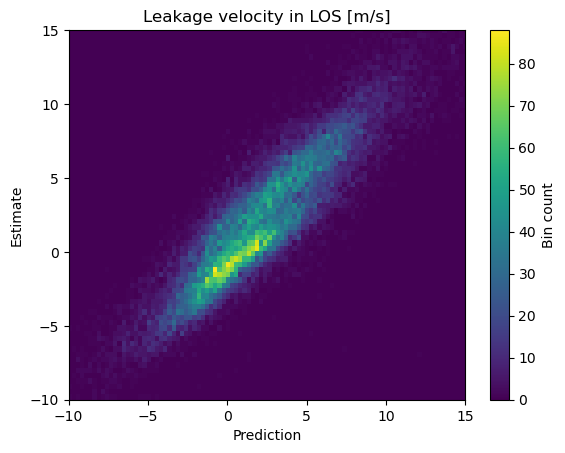

{'bayesianridge_best': [[1.6965574948155606, 0.018917617365346813],
  [0.6075947122337529, 0.006330493964546258]],
 'lightgbm_best': [[1.4092781002490085, 0.016931855477202856],
  [0.7976514026502601, 0.0036824128869723744]],
 'stacked': [[1.3462457072461025, 0.015041901455711354],
  [0.8154682013583644, 0.005548763925790694]]}

In [22]:
plt.hist2d(ML2.y_pred, np.ravel(ML2.y_test.values), bins=(200,200)) #, gridsize=10, cmap='Blues', edgecolors='gray', mincnt=1)
plt.xlim([-10, 15]); plt.ylim([-10, 15])
plt.colorbar(label='Bin count')
plt.title('Leakage velocity in LOS [m/s]')
plt.xlabel('Prediction')
plt.ylabel('Estimate')
plt.show()

ML2.summary